## Table of Contents

1. [Data Preparation](#nndataprep)
2. [Initial Neural Network Model](#firstmodel)
3. [Second Neural Network Model](#2ndmodel)
4. [Third Neural Network Model](#3rdmodel)
5. [Neural Network Model + GridSearch CV](#section5)
6. [Final Neural Network Model + Best Parameters](#section6)

## Data Preparation <a id='nndataprep'></a>

### Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras 
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, validation_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, auc, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score
from sklearn.dummy import DummyClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD


%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
def plot_roc_curve(test, model_probs, naive_probs):
    fpr, tpr, _ = roc_curve(test, naive_probs)
    plt.plot(fpr, tpr, linestyle = '--', label = 'Baseline')
    fpr, tpr, _ = roc_curve(test, model_probs)
    plt.plot(fpr, tpr, marker = '.', label = 'Neural Network', markersize = 0.1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.title('ROC Curve')
    plt.show()
    
def plot_pr_curve(test, model_probs):
    no_skill = len(test[test == 1]) / len(test)
    
    plt.plot( [no_skill, no_skill], linestyle = '--', label = 'Baseline')
    
    precision, recall, _ = precision_recall_curve(test, model_probs)
    plt.plot(recall, precision, marker = '.', label = 'Neural Network', markersize = 0.1)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision - Recall Curve')
    plt.legend()
    plt.show()

### Setting Up Data

In [3]:
#Reading in dataset with random forest feature selection
df = pd.read_csv('../data/loan_rf_features.csv')

In [4]:
#Setting up X and y
X = pd.get_dummies(df.drop(columns = ['loan_status']))
y = df['loan_status']

In [5]:
#Train, test, split with scaling
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state = 42,
                                                    stratify = y,
                                                    test_size= 0.2)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

n_input = X_train.shape[1]


In [4]:
#Baseline model
dummy_model = DummyClassifier(strategy= 'stratified')
dummy_model.fit(X_train, y_train)
naive_preds = dummy_model.predict_proba(X_test)[:, 1]

### Initial Neural Network Model <a id='firstmodel'></a>

In [33]:
#Setting up model structure
model = Sequential()

model.add(Dense(32, input_dim = n_input, activation = 'relu')) 
model.add(Dense(32, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

opt = SGD(learning_rate = 0.001) #adam was inititally attempted but showed no learning rate, wanted to attempt with SGD optimizer

model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = [ 'Recall', 'Precision',  keras.metrics.AUC(name='prc', curve='PR'), 'accuracy'])

In [34]:
#Fitting model
history = model.fit(X_train,
                    y_train,
                    validation_data = (X_test, y_test),
                    epochs = 30,
                    batch_size = 256,
                    verbose = 1)

Epoch 1/30
4012/4012 [==============================] - 5s 1ms/step - loss: 0.4502 - recall: 0.0230 - precision: 0.3237 - prc: 0.2287 - accuracy: 0.8151 - val_loss: 0.3708 - val_recall: 0.0896 - val_precision: 0.8291 - val_prc: 0.3303 - val_accuracy: 0.8324
Epoch 2/30
4012/4012 [==============================] - 4s 1ms/step - loss: 0.3144 - recall: 0.3876 - precision: 0.7687 - prc: 0.4471 - accuracy: 0.8685 - val_loss: 0.2709 - val_recall: 0.5963 - val_precision: 0.7493 - val_prc: 0.5413 - val_accuracy: 0.8912
Epoch 3/30
4012/4012 [==============================] - 4s 1ms/step - loss: 0.2558 - recall: 0.6543 - precision: 0.7395 - prc: 0.5892 - accuracy: 0.8961 - val_loss: 0.2453 - val_recall: 0.6841 - val_precision: 0.7402 - val_prc: 0.6231 - val_accuracy: 0.8997
Epoch 4/30
4012/4012 [==============================] - 4s 1ms/step - loss: 0.2420 - recall: 0.6989 - precision: 0.7359 - prc: 0.6450 - accuracy: 0.9004 - val_loss: 0.2379 - val_recall: 0.7055 - val_precision: 0.7380 - val_prc

In [30]:
#Creating a function to aid with plotting our metrics and loss
def plot_history(history):
    train_loss = history.history['loss']
    test_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    test_acc = history.history['val_accuracy']
    train_prc = history.history['prc']
    test_prc = history.history['val_prc']
    
    plt.figure(figsize = (12, 8))
    plt.plot(train_loss, label = 'Training Loss', color = 'purple')
    plt.plot(test_loss, label = 'Testing Loss', color = 'pink')
    plt.plot(train_acc, label = 'Training Accuracy', color = 'navy')
    plt.plot(test_acc, label = 'Testing Accuracy', color = 'skyblue')
    plt.plot(train_prc, label = 'Training PRC Score', color = 'green')
    plt.plot(test_prc, label = 'Testing PRC Score', color = 'lightgreen')
    plt.xlabel('# of epochs')
    plt.ylabel('Score')
    plt.title('Loss and Evaluation Metrics Curve')
    plt.legend()
    plt.show();

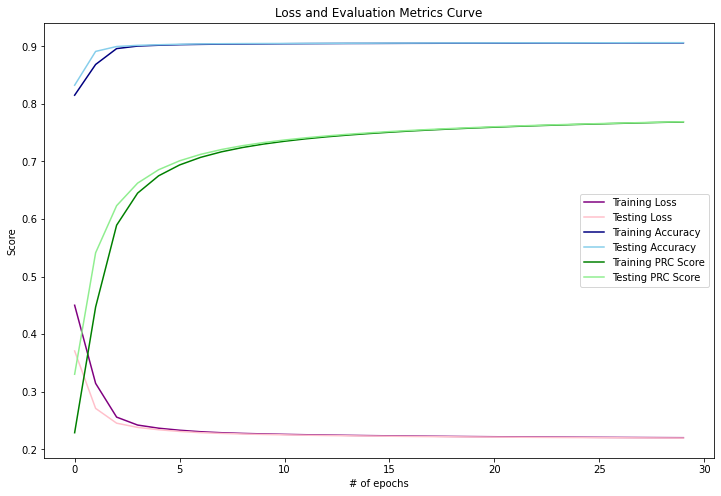

In [35]:

plot_history(history)

In [13]:
#Generating predictions, already probabilities
nn_train_preds = model.predict(X_train)
nn_test_preds = model.predict(X_test)

In [14]:
#Accuracy score for initial model
accuracy_score(y_test, nn_test_preds.round())

0.9062441577865021

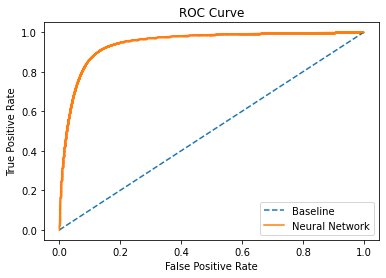

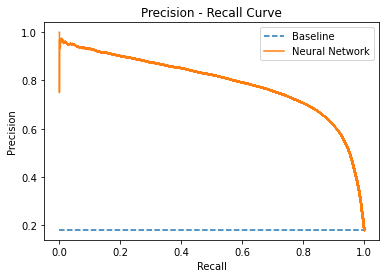

Training Data ROC-AUC score neural network: 0.945
Testing Data ROC-AUC score neural network: 0.946
TrainingData PR-AUC score KNN (initial): 0.790
Testing Data PR-AUC score KNN (initial): 0.792


In [18]:
#Plotting relevant curves and evaluation metrics
plot_roc_curve(y_test, nn_test_preds, naive_preds)
plot_pr_curve(y_test, nn_test_preds)
print(f'Training Data ROC-AUC score neural network: {roc_auc_score(y_train, nn_train_preds):.3f}')
print(f'Testing Data ROC-AUC score neural network: {roc_auc_score(y_test, nn_test_preds):.3f}')

precision, recall, _ = precision_recall_curve(y_train, nn_train_preds)
print(f'TrainingData PR-AUC score KNN (initial): {auc(recall, precision):.3f}')

precision, recall, _ = precision_recall_curve(y_test, nn_test_preds)
print(f'Testing Data PR-AUC score KNN (initial): {auc(recall, precision):.3f}')

### Second Neural Network Model <a id='2ndmodel'></a>

In [26]:
#Setting up model structure
model2 = Sequential()

model2.add(Dense(24, input_dim = n_input, activation = 'relu')) #Reduced number of neurons in initial layer and hidden layers
model2.add(Dense(12, activation = 'relu'))
model2.add(Dense(12, activation = 'relu'))
model2.add(Dense(1, activation = 'sigmoid'))

opt = SGD(learning_rate = 0.001)
model2.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['Recall', 'Precision',  keras.metrics.AUC(name='prc', curve='PR'), 'accuracy'])

In [27]:
#Fitting model
history2 = model2.fit(X_train,
                    y_train,
                    validation_data = (X_test, y_test),
                    epochs = 30,
                    verbose = 1,
                    batch_size = 256,
                    class_weight = {1 : 0.8, 0 : 0.2}) #introduced class weight into model to prioritize minority class

Epoch 1/30
4012/4012 [==============================] - 6s 1ms/step - loss: 0.2122 - recall: 0.6315 - precision: 0.2077 - prc: 0.2142 - accuracy: 0.4990 - val_loss: 0.6824 - val_recall: 0.5374 - val_precision: 0.2313 - val_prc: 0.2208 - val_accuracy: 0.5943
Epoch 2/30
4012/4012 [==============================] - 4s 1ms/step - loss: 0.2071 - recall: 0.4880 - precision: 0.2535 - prc: 0.2273 - accuracy: 0.6484 - val_loss: 0.6444 - val_recall: 0.4615 - val_precision: 0.2824 - val_prc: 0.2344 - val_accuracy: 0.6913
Epoch 3/30
4012/4012 [==============================] - 4s 1ms/step - loss: 0.2012 - recall: 0.4697 - precision: 0.3075 - prc: 0.2422 - accuracy: 0.7135 - val_loss: 0.6054 - val_recall: 0.4975 - val_precision: 0.3384 - val_prc: 0.2516 - val_accuracy: 0.7339
Epoch 4/30
4012/4012 [==============================] - 4s 1ms/step - loss: 0.1914 - recall: 0.5431 - precision: 0.3649 - prc: 0.2626 - accuracy: 0.7471 - val_loss: 0.5544 - val_recall: 0.6011 - val_precision: 0.3950 - val_prc

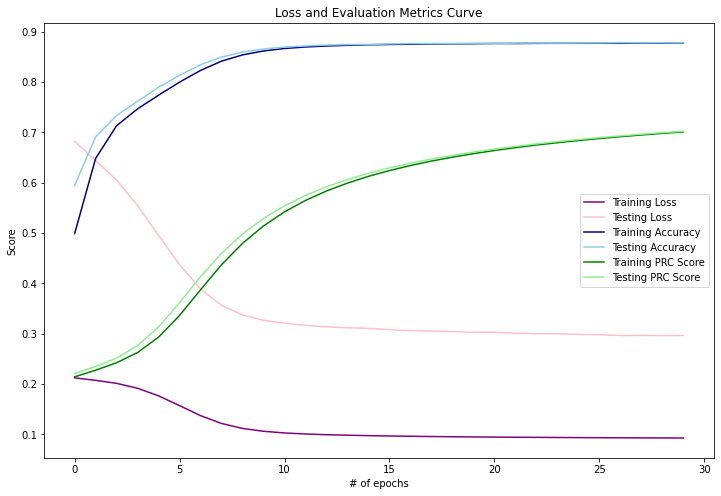

In [31]:
plot_history(history2)

### Third Neural Network Model (L2 regularization) <a id='3rdmodel'></a>

In [52]:
#Setting up network structure
model3 = Sequential()

model3.add(Dense(32, input_dim = n_input, activation = 'relu'))
model3.add(Dense(32, activation = 'relu', kernel_regularizer = l2(0.001))) #introducing l2 regularization for both hidden layers
model3.add(Dense(16, activation = 'relu', kernel_regularizer = l2(0.001))) #reduced neurons in this layer as well as adding l2 regularization
model3.add(Dense(1, activation = 'sigmoid'))

opt = SGD(learning_rate = 0.001)
model3.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = [ 'Recall', 'Precision',  keras.metrics.AUC(name='prc', curve='PR'), 'accuracy'])

In [53]:
#Fitting neural network
history3 = model3.fit(X_train,
                    y_train,
                    validation_data = (X_test, y_test),
                    epochs = 30,
                    verbose = 2,
                    batch_size = 256,) #removed class weight, caused large increase in testing loss

Epoch 1/30
4012/4012 - 5s - loss: 0.5195 - recall: 0.0150 - precision: 0.2768 - prc: 0.2386 - accuracy: 0.8153 - val_loss: 0.4508 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_prc: 0.2636 - val_accuracy: 0.8196
Epoch 2/30
4012/4012 - 4s - loss: 0.4101 - recall: 0.0181 - precision: 0.8093 - prc: 0.3149 - accuracy: 0.8221 - val_loss: 0.3684 - val_recall: 0.1297 - val_precision: 0.8024 - val_prc: 0.3912 - val_accuracy: 0.8372
Epoch 3/30
4012/4012 - 4s - loss: 0.3408 - recall: 0.4259 - precision: 0.7540 - prc: 0.4696 - accuracy: 0.8714 - val_loss: 0.3161 - val_recall: 0.6145 - val_precision: 0.7384 - val_prc: 0.5298 - val_accuracy: 0.8912
Epoch 4/30
4012/4012 - 4s - loss: 0.3060 - recall: 0.6655 - precision: 0.7279 - prc: 0.5655 - accuracy: 0.8948 - val_loss: 0.2958 - val_recall: 0.6994 - val_precision: 0.7283 - val_prc: 0.5926 - val_accuracy: 0.8987
Epoch 5/30
4012/4012 - 4s - loss: 0.2934 - recall: 0.7151 - precision: 0.7241 - prc: 0.6119 - accuracy: 0.8994 - val_loss: 0.288

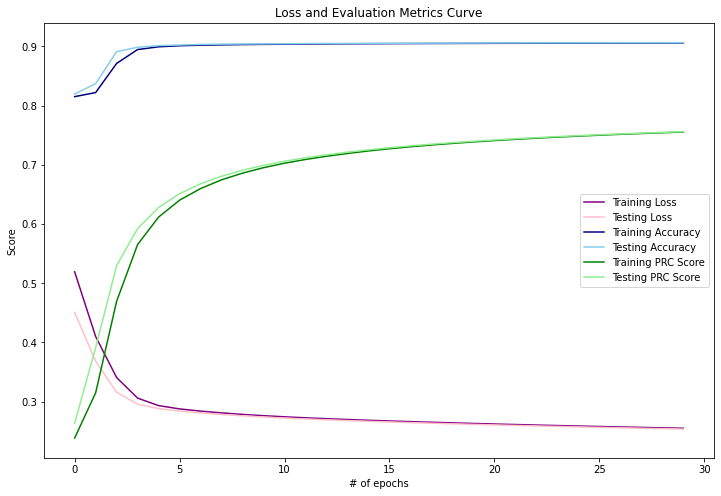

In [54]:
#Plot for 3rd neural network
plot_history(history3)

### Third Neural Network Model (Dropout) <a id='section4'></a>

In [40]:
#Setting up network structure
model3 = Sequential()

model3.add(Dense(32, input_dim = n_input, activation = 'relu'))
model3.add(Dense(32, activation = 'relu'))
model3.add(Dropout(0.2))
model3.add(Dense(16, activation = 'relu'))
model3.add(Dropout(0.2))
model3.add(Dense(1, activation = 'sigmoid'))

opt = SGD(learning_rate = 0.001)
model3.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = [ 'Recall', 'Precision',  keras.metrics.AUC(name='prc', curve='PR'), 'accuracy'])

In [41]:
history3 = model3.fit(X_train,
                    y_train,
                    validation_data = (X_test, y_test),
                    epochs = 50,
                    verbose = 1,
                    batch_size = 128,
                    ) #Removed class weight, seems to have caused the model 

Epoch 1/50
8024/8024 [==============================] - 10s 1ms/step - loss: 0.4407 - recall: 0.0370 - precision: 0.4980 - prc: 0.2544 - accuracy: 0.8196 - val_loss: 0.3479 - val_recall: 0.0926 - val_precision: 0.8135 - val_prc: 0.3625 - val_accuracy: 0.8325
Epoch 2/50
8024/8024 [==============================] - 9s 1ms/step - loss: 0.3300 - recall: 0.2902 - precision: 0.7087 - prc: 0.4448 - accuracy: 0.8504 - val_loss: 0.2679 - val_recall: 0.5720 - val_precision: 0.7452 - val_prc: 0.5148 - val_accuracy: 0.8875
Epoch 3/50
8024/8024 [==============================] - 9s 1ms/step - loss: 0.2771 - recall: 0.5610 - precision: 0.7069 - prc: 0.5579 - accuracy: 0.8788 - val_loss: 0.2401 - val_recall: 0.7220 - val_precision: 0.7214 - val_prc: 0.5908 - val_accuracy: 0.8995
Epoch 4/50
8024/8024 [==============================] - 9s 1ms/step - loss: 0.2587 - recall: 0.6601 - precision: 0.7072 - prc: 0.6135 - accuracy: 0.8894 - val_loss: 0.2323 - val_recall: 0.7568 - val_precision: 0.7168 - val_pr

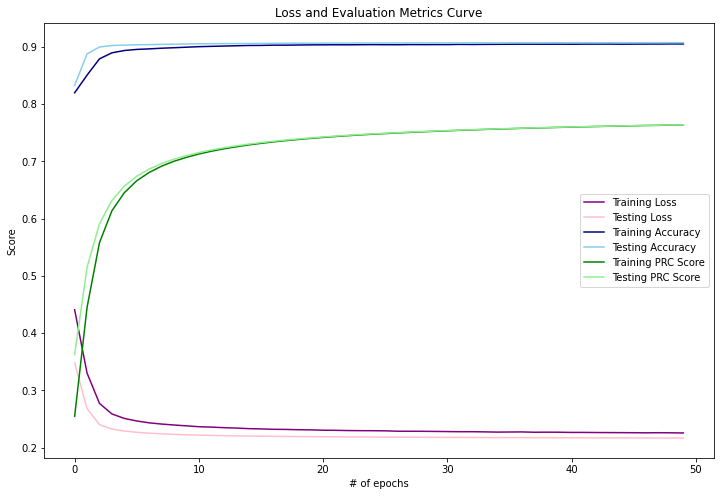

In [55]:
plot_history(history4)

### Deep Neural Network GridSearchCV <a id='section5'></a>

In [43]:
#Defining function to throw into build_fn for kerasclassifier
#Dropout used over l2 due to higher PRC-AUC score
def model_deep(hidden_neurons, hidden_layers, dropout):
    model = Sequential()
    for layer in range(hidden_layers):
        if layer == 0:
            model.add(Dense(hidden_neurons, activation = 'relu', input_dim = n_input))
            model.add(Dropout(dropout))
        else:
            model.add(Dense(hidden_neurons / 2, activation = 'relu'))
            model.add(Dropout(dropout))
    
    model.add(Dense(1, activation = 'sigmoid'))
    
    model.compile(loss = 'bce', optimizer = 'adam', metrics = [ 'Recall', 'Precision',  keras.metrics.AUC(name='prc', curve='PR'), 'accuracy'])
    
    return model

#Parameters for gridsearch - we 
params_deep = {
    'hidden_neurons' : [24, 32], #tuning for number of neurons
    'hidden_layers'  : [2, 3], #tuning for number of hidden layers
    'dropout'        : [0.1, 0.2, 0.5], #tuning for dropout parameter
    'epochs'         : [30], #using 30 epochs
}

nn = KerasClassifier(build_fn = model_deep, batch_size = 512)

gs_deep = GridSearchCV(estimator = nn, param_grid = params_deep, cv = 3, verbose = 1)
gs_deep.fit(X_train, y_train, validation_data = (X_test, y_test))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Epoch 1/30
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2690 - recall: 0.6712 - precision: 0.7434 - prc: 0.6530 - accuracy: 0.8884 - val_loss: 0.2271 - val_recall: 0.7839 - val_precision: 0.7464 - val_prc: 0.7645 - val_accuracy: 0.9041
Epoch 2/30
1375/1375 [==============================] - 3s 2ms/step - loss: 0.2300 - recall: 0.7832 - precision: 0.7479 - prc: 0.7788 - accuracy: 0.9042 - val_loss: 0.2243 - val_recall: 0.7999 - val_precision: 0.7420 - val_prc: 0.7869 - val_accuracy: 0.9050
Epoch 3/30
1375/1375 [==============================] - 3s 2ms/step - loss: 0.2270 - recall: 0.7806 - precision: 0.7530 - prc: 0.7919 - accuracy: 0.9053 - val_loss: 0.2230 - val_recall: 0.7823 - val_precision: 0.7523 - val_prc: 0.7952 - val_accuracy: 0.9056
Epoch 4/30
1375/1375 [==============================] - 3s 2ms/step - loss: 0.2256 - recall: 0.7749 - precision: 0.7566 - prc: 0.7978 - accuracy: 0.9055 - val_loss: 

GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000001D47B9F3E50>,
             param_grid={'dropout': [0.1, 0.2, 0.5], 'epochs': [30],
                         'hidden_layers': [2, 3], 'hidden_neurons': [24, 32]},
             verbose=1)

In [56]:
#Best parameters
gs_deep.best_params_

{'dropout': 0.1, 'epochs': 30, 'hidden_layers': 2, 'hidden_neurons': 32}

In [44]:
#Testing data accuracy score
gs_deep.score(X_test, y_test)

516/516 [==============================] - 1s 1ms/step - loss: 0.2197 - recall: 0.7672 - precision: 0.7628 - prc: 0.8182 - accuracy: 0.9063


0.9063288569450378

In [45]:
#Training data accuracy score
gs_deep.score(X_train, y_train)

2062/2062 [==============================] - 3s 1ms/step - loss: 0.2164 - recall: 0.7696 - precision: 0.7656 - prc: 0.8183 - accuracy: 0.9074


0.9073765873908997

In [50]:
#Generating prediction probabilities
deep_train_probs = gs_deep.predict_proba(X_train)[:,1]
deep_test_probs = gs_deep.predict_proba(X_test)[:,1]
deep_train_preds = gs_deep.predict(X_train)
deep_test_preds = gs_deep.predict(X_test)


C:\Users\eddie\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [52]:
#Precision score 
precision_score(y_test, deep_test_preds)

0.7627822328385372

In [54]:
#Recall score
recall_score(y_test, deep_test_preds)

0.7672329958240375

### Final Model with Best Parameters <a id='section6'></a>

In [60]:
#Setting up model and fitting
best_model = Sequential()

best_model.add(Dense(32, activation = 'relu', input_dim = n_input))
best_model.add(Dropout(0.1))
best_model.add(Dense(16, activation = 'relu'))
best_model.add(Dropout(0.1))
best_model.add(Dense(1, activation = 'sigmoid'))

best_model.compile(loss = 'bce', optimizer = 'adam', metrics = [ 'Recall', 'Precision',  keras.metrics.AUC(name='prc', curve='PR'), 'accuracy'])

best_history = best_model.fit(X_train, y_train,
                              validation_data = (X_test, y_test),
                              epochs = 30,
                              batch_size = 512,
                              verbose = 1)

Epoch 1/30
2006/2006 [==============================] - 5s 2ms/step - loss: 0.2493 - recall: 0.6776 - precision: 0.7157 - prc: 0.6495 - accuracy: 0.8933 - val_loss: 0.2161 - val_recall: 0.7453 - val_precision: 0.7421 - val_prc: 0.7553 - val_accuracy: 0.9073
Epoch 2/30
2006/2006 [==============================] - 4s 2ms/step - loss: 0.2212 - recall: 0.7415 - precision: 0.7383 - prc: 0.7675 - accuracy: 0.9060 - val_loss: 0.2151 - val_recall: 0.7397 - val_precision: 0.7459 - val_prc: 0.7743 - val_accuracy: 0.9076
Epoch 3/30
2006/2006 [==============================] - 4s 2ms/step - loss: 0.2193 - recall: 0.7396 - precision: 0.7415 - prc: 0.7778 - accuracy: 0.9065 - val_loss: 0.2147 - val_recall: 0.7371 - val_precision: 0.7483 - val_prc: 0.7809 - val_accuracy: 0.9078
Epoch 4/30
2006/2006 [==============================] - 4s 2ms/step - loss: 0.2185 - recall: 0.7383 - precision: 0.7436 - prc: 0.7828 - accuracy: 0.9069 - val_loss: 0.2150 - val_recall: 0.7178 - val_precision: 0.7577 - val_prc

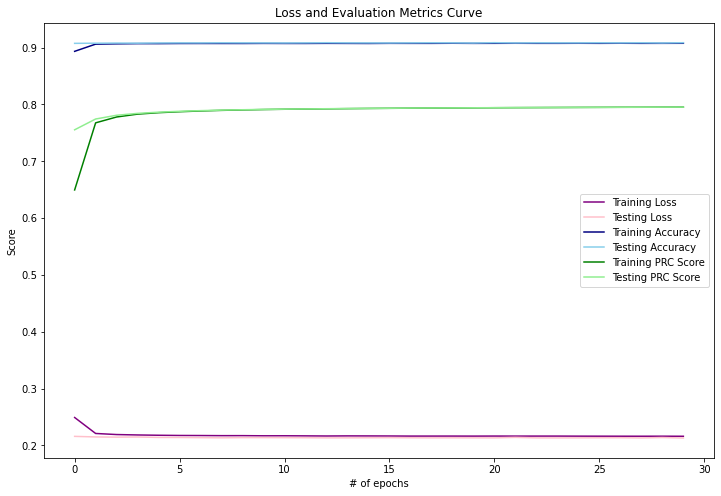

In [61]:
#Plotting curve for best neural network
plot_history(best_history)

In [64]:
#Generating predictions and exporting
dnn_test_probs = best_model.predict_proba(X_test)
dnn_probs = pd.DataFrame(dnn_test_probs, columns = ['dnn_probs'])

In [ ]:
dnn_probs.to_csv('../data/dnn_probs.csv')